<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install HuggingFace Transformers and HuggingFace Datasets.

In [1]:
!pip install -q transformers datasets

     |████████████████████████████████| 3.1 MB 13.5 MB/s 
     |████████████████████████████████| 290 kB 50.7 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 50.6 MB/s 
     |████████████████████████████████| 3.3 MB 40.5 MB/s 
     |████████████████████████████████| 243 kB 52.1 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 132 kB 39.6 MB/s 
     |████████████████████████████████| 192 kB 50.3 MB/s 
     |████████████████████████████████| 160 kB 48.5 MB/s 
     |████████████████████████████████| 271 kB 50.7 MB/s 


## Load model and feature extractor

Here we load the model as well as the feature extractor from the [HuggingFace Hub](https://huggingface.co/). Note that NVIDIA has released several checkpoints, all of which can be found [here](https://huggingface.co/models?other=segformer). Be sure to play around with them!

The feature extractor can be used to prepare images for the model.

We move the model to GPU if it's available.

In [3]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

Downloading:   0%|          | 0.00/510 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/324M [00:00<?, ?B/s]

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## Prepare image

Here, we load an image from the ADE20k dataset (actually called the [MIT Scene Parsing Benchmark](http://sceneparsing.csail.mit.edu/)), an important benchmark for semantic segmentation. We also load its corresponding ground truth segmentation map.

Downloading:   0%|          | 0.00/2.79k [00:00<?, ?B/s]

No config specified, defaulting to: fixtures_ade20k/image


  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset fixtures_ade20k downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___fixtures_ade20k/image/1.9.0/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db. Subsequent calls will reuse this data.


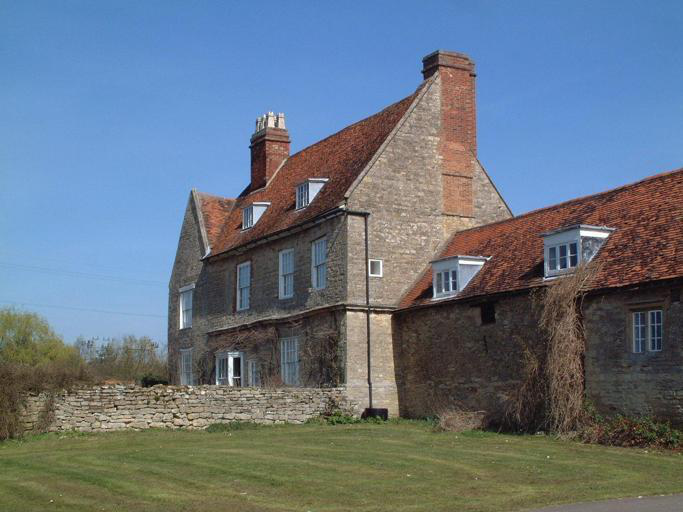

In [4]:
from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
segmentation_map = Image.open(ds[1]["file"])
image

We can prepare the image for the model using the feature extractor. It will resize the image + normalize the channels.

In [5]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values.to(device)

## Forward pass

Next, let's forward the pixel values through the model in order to obtain the logits.

In [6]:
outputs = model(pixel_values)
logits = outputs.logits

## Visualize

Finally, let's visualize the segmentation map as predicted by the model. Semantic segmentation datasets typically define what is called a "palette", that defines the RGB values to use for each of the classes. 

The ADE20k dataset consists of 150 classes, so the list below has 150 elements.

In [7]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

The model outputs logits of shape `(batch_size, num_labels, height/4, width/4)`.  We first rescale the logits to match the original size of the image using bilinear interpolation. Next, we perform an argmax on the class dimension, and we create a color map which we draw over the image.

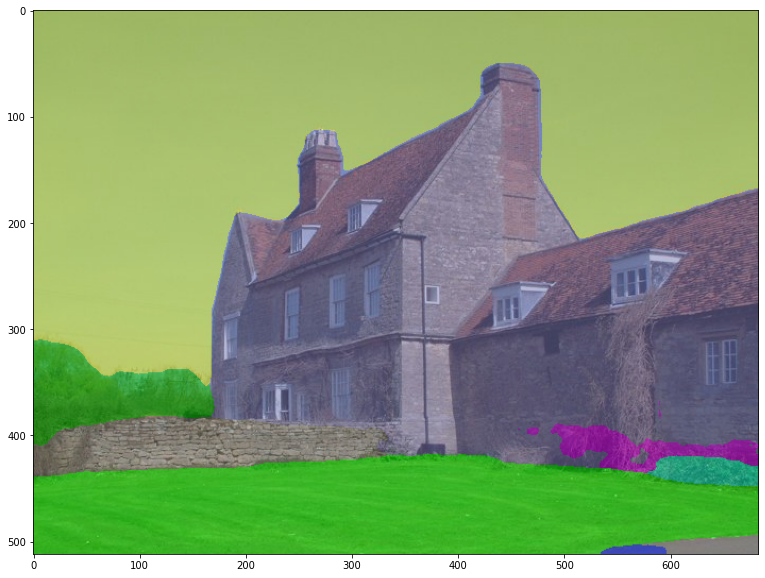

In [8]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(outputs.logits.detach().cpu(),
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth:

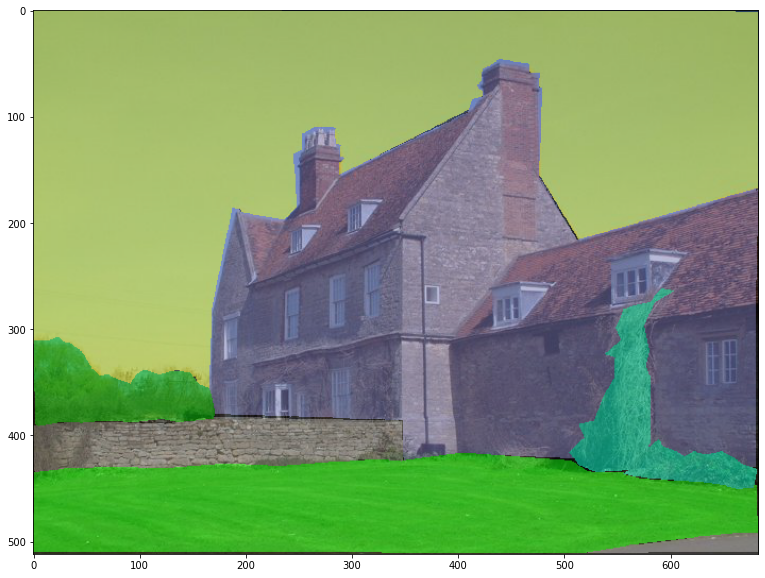

In [9]:
import numpy as np

ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()